In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

### data load

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("")
print("train.num =", mnist.train.num_examples,
     ", test.num =", mnist.test.num_examples,
     ", validation.num =", mnist.validation.num_examples)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

train.num = 55000 , test.num = 10000 , validation.num = 5000


### hyper parameter 

In [3]:
# Hyper-Parameter
learning_rate = 1e-3
epochs = 30
batch_size = 100

In [4]:
# 입력과 정답을 위한 플레이스홀더 정의
X = tf.placeholder(tf.float32, [None, 784])  
T = tf.placeholder(tf.float32, [None, 10])  

# 입력층의 출력 값. 컨볼루션 연산을 위해 reshape 시킴
A1 = X_img = tf.reshape(X, [-1, 28, 28, 1])  # image 28 x 28 x 1 (black / white)

### 컨볼루션층 1 3x3 32개 -> 5x5 32개

In [5]:
# 1번째 컨볼루션 층, 3x3x32 필터 
W2 = tf.Variable(tf.random_normal([5, 5, 1, 32], stddev=0.01))  # standard deviation 표준편차 0.01 이내로 뽑음 -> 더 정교한 데이터
b2 = tf.Variable(tf.random_normal([32]))
## b2 = tf.Variable(tf.constant(0.1, shape=[32]))

# 1번째 컨볼루션 연산을 통해 28 x 28 x 1 => 28 x 28 x 32  흑백인 1개 층이 -> 32개 층을 거치게 됨
C2 = tf.nn.conv2d(A1, W2, strides=[1, 1, 1, 1], padding='SAME')

# relu
Z2 = tf.nn.relu(C2+b2)

# 1번째 max pooling을 통해 28 x 28 x 32 => 14 x 14 x 32  max pooling을 통해 4개를 1개로 묶어 가로 세로 2배씩 줄어들게 됨
A2 = P2 = tf.nn.max_pool(Z2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### 컨볼루션층 2 3x3 32개 -> 5x5 64개

In [7]:
# 2번째 컨볼루션 층, 3x3x32 필터 
W3 = tf.Variable(tf.random_normal([5, 5, 32, 64], stddev=0.01)) ## 데이터 1개에 대해 필터를 거쳐 특징의 종류가 32개
## 32 개 통로로 들어오는 각각의 데이터에 대해 5 x 5 64개 필터를 적용함

b3 = tf.Variable(tf.random_normal([64]))
## b3 = tf.Variable(tf.constant(0.1, shape=[64]))

# 2번째 컨볼루션 연산을 통해 14 x 14 x 32 => 14 x 14 x 64 
C3 = tf.nn.conv2d(A2, W3, strides=[1, 1, 1, 1], padding='SAME')

# relu
Z3 = tf.nn.relu(C3+b3)

# 1번째 max pooling을 통해 14 x 14 x 64 => 7 x 7 x 64
A3 = P3 = tf.nn.max_pool(Z3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### 완전연결층 

In [8]:
# 7 x 7 크기를 가진 32개의 activation map을 flatten 시킴
A3_flat = P3_flat = tf.reshape(A3, [-1, 7*7*64])

### 출력층

In [9]:
# 출력층
W4 = tf.Variable(tf.random_normal([7*7*64, 10], stddev=0.01))
b4 = tf.Variable(tf.random_normal([10]))

# 출력층 선형회귀 값 Z4, 즉 softmax 에 들어가는 입력 값
Z4 = logits = tf.matmul(A3_flat, W4) + b4

y = A4 = tf.nn.softmax(Z4)

In [10]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z4, labels = T))

optimizer = tf.train.AdamOptimizer(learning_rate)

train = optimizer.minimize(loss)

In [11]:
# batch_size x 10 데이터에 대해 argmax를 통해 행단위로 비교함
predicted_val = tf.equal(tf.argmax(A4, 1), tf.argmax(T, 1))

# batch_size x 10 의 True, False 를 1 또는 0 으로 변환
accuracy = tf.reduce_mean(tf.cast(predicted_val, dtype=tf.float32))

# index list 출력
accuracy_index = tf.cast(predicted_val, dtype=tf.float32)

predicted_list = tf.argmax(A4, 1)

In [12]:
index_label_false_list_1 = []

with tf.Session() as sess:  # with를 쓰면 close 하지 않아도 됨
    sess.run(tf.global_variables_initializer())  # 변수 노드 (tf.Variable) 초기화
    
    start_time = datetime.now()
    
    for i in range(epochs):  # 30번 반복 수행
        total_batch = int(mnist.train.num_examples / batch_size)  # 55000 / 100
        
        for step in range(total_batch):
            batch_x_data, batch_t_data = mnist.train.next_batch(batch_size)
            
            loss_val, _ = sess.run([loss, train], feed_dict={X: batch_x_data, T: batch_t_data})   
        
            if step % 100 == 0:
                print("epochs = ", i, ", step = ", step, ", loss_val = ", loss_val)             
    
    end_time = datetime.now()
    
    print("")
    print("Elapsed Time => ", end_time-start_time)
    
    # Accuracy 확인
    test_x_data = mnist.test.images  # 10000 x 784
    test_t_data = mnist.test.labels  # 10000 x 10
    
    accuracy_val, predicted_list_val, index_label = sess.run([accuracy, predicted_list, accuracy_index], feed_dict={X: test_x_data, T: test_t_data})
    
    print("\nAccuracy =", accuracy_val)
    
    index_label_list = list(index_label)
    print("length of index_label_list = ", len(index_label_list))
    print("false label count = ", index_label_list.count([0]))
    
    # list type 으로 디버그
    temp_list = [] 
    
    for index in range(len(index_label_list)):
        
        if index_label_list[index] == 0:
            
            temp_list.append(index)
            temp_list.append(np.argmax(test_t_data[index]))  # one-hot encoding 이므로 argmax 로 정답 추출
            temp_list.append(predicted_list_val[index])
            
            index_label_false_list_1.append(temp_list)
            
            temp_list = []
            
    print("\nlength of index_label_false_list_1", len(index_label_false_list_1))

epochs =  0 , step =  0 , loss_val =  2.5644913
epochs =  0 , step =  100 , loss_val =  1.6795496
epochs =  0 , step =  200 , loss_val =  0.34544814
epochs =  0 , step =  300 , loss_val =  0.21441732
epochs =  0 , step =  400 , loss_val =  0.10442747
epochs =  0 , step =  500 , loss_val =  0.14969708
epochs =  1 , step =  0 , loss_val =  0.08363062
epochs =  1 , step =  100 , loss_val =  0.07350081
epochs =  1 , step =  200 , loss_val =  0.16348366
epochs =  1 , step =  300 , loss_val =  0.2565182
epochs =  1 , step =  400 , loss_val =  0.035714902
epochs =  1 , step =  500 , loss_val =  0.034971803
epochs =  2 , step =  0 , loss_val =  0.069787584
epochs =  2 , step =  100 , loss_val =  0.078500405
epochs =  2 , step =  200 , loss_val =  0.07703281
epochs =  2 , step =  300 , loss_val =  0.07332486
epochs =  2 , step =  400 , loss_val =  0.031199927
epochs =  2 , step =  500 , loss_val =  0.0368712
epochs =  3 , step =  0 , loss_val =  0.042048052
epochs =  3 , step =  100 , loss_val 

epochs =  26 , step =  100 , loss_val =  0.013110106
epochs =  26 , step =  200 , loss_val =  0.003151434
epochs =  26 , step =  300 , loss_val =  0.0045787864
epochs =  26 , step =  400 , loss_val =  0.0007008843
epochs =  26 , step =  500 , loss_val =  0.013793596
epochs =  27 , step =  0 , loss_val =  0.002181731
epochs =  27 , step =  100 , loss_val =  0.00659194
epochs =  27 , step =  200 , loss_val =  0.008791451
epochs =  27 , step =  300 , loss_val =  0.004924037
epochs =  27 , step =  400 , loss_val =  0.00648095
epochs =  27 , step =  500 , loss_val =  0.003438614
epochs =  28 , step =  0 , loss_val =  0.022680122
epochs =  28 , step =  100 , loss_val =  6.7973146e-05
epochs =  28 , step =  200 , loss_val =  0.0005137474
epochs =  28 , step =  300 , loss_val =  0.003573421
epochs =  28 , step =  400 , loss_val =  0.00039270942
epochs =  28 , step =  500 , loss_val =  0.00097082404
epochs =  29 , step =  0 , loss_val =  0.0036345078
epochs =  29 , step =  100 , loss_val =  0.0

In [13]:
print(index_label_false_list_1)

[[62, 9, 5], [115, 4, 9], [247, 4, 2], [259, 6, 0], [321, 2, 7], [340, 5, 3], [445, 6, 0], [447, 4, 7], [582, 8, 2], [583, 2, 7], [674, 5, 3], [939, 2, 0], [947, 8, 9], [1014, 6, 0], [1039, 7, 3], [1112, 4, 6], [1226, 7, 2], [1232, 9, 4], [1242, 4, 9], [1319, 8, 0], [1393, 5, 3], [1459, 2, 7], [1641, 5, 9], [1709, 9, 5], [1737, 5, 2], [1790, 2, 7], [1865, 4, 7], [1899, 8, 7], [1901, 9, 4], [1982, 6, 5], [2035, 5, 3], [2040, 5, 8], [2098, 2, 0], [2118, 6, 0], [2130, 4, 9], [2135, 6, 1], [2293, 9, 4], [2387, 9, 1], [2406, 9, 4], [2414, 9, 4], [2597, 5, 3], [2654, 6, 1], [2720, 9, 4], [2760, 9, 4], [2927, 3, 7], [2939, 9, 5], [2953, 3, 5], [3005, 9, 8], [3030, 6, 0], [3073, 1, 2], [3225, 7, 9], [3336, 5, 9], [3337, 2, 7], [3384, 2, 6], [3422, 6, 0], [3475, 3, 7], [3503, 9, 1], [3520, 6, 4], [3534, 4, 8], [3558, 5, 0], [3794, 8, 3], [3808, 7, 8], [3853, 6, 0], [3985, 9, 4], [4007, 7, 4], [4075, 8, 0], [4176, 2, 7], [4205, 2, 8], [4224, 9, 7], [4248, 2, 7], [4497, 8, 7], [4507, 1, 9], [4536

### 파일로 이미지 저장

In [14]:
# check false data
import os

save_count = 0

# 현재 디렉토리 저장
curr_dir = os.getcwd()
print(curr_dir)

C:\Users\YUSEUNG\OneDrive - konkuk.ac.kr\DESKTOP\AI 기본과정\실습\16일차_1124


10 image is saved now
20 image is saved now
30 image is saved now
40 image is saved now
50 image is saved now
60 image is saved now
70 image is saved now
80 image is saved now
90 image is saved now
100 image is saved now
Elapsed save time =>  0:00:40.718547
Total  108  data is saved


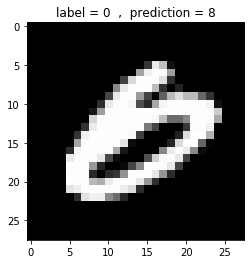

In [15]:
# image 저장할 디렉토리 생성. 현재 시간으로 생성
now = datetime.now()
algorithm_name = 'false_data_실습4'
save_dir_name = algorithm_name + '_' + str(now.year) + str(now.month) + str(now.day) + '_' + str(now.hour) + str(now.minute) + str(now.second)

os.chdir(curr_dir)
os.mkdir(save_dir_name)

# change dir
os.chdir(save_dir_name)

start_time = datetime.now()

for list_data in index_label_false_list_1:
    
    index_int = list_data[0]
    label_int = list_data[1]
    prediction_int = list_data[2]
        
    # 저장할 이미지를 인덱스를 이용하여 가져옴
    img = test_x_data[index_int].reshape(28,28)  
    plt.imshow(img, cmap='gray')
    
    # 정답 문자열
    label_str = str(label_int)
    
    # 예측값 문자열
    prediction_str = str(prediction_int)
    
    # 정답과 오답을 나타내는 문자열
    label_prediction_str = 'label = ' + label_str + '  ,  prediction = ' + prediction_str
    
    # 저장 파일 이름 생성, str(index_int).png
    save_image_name = str(index_int) + '.png'
    
    plt.title(label_prediction_str)
    plt.savefig(save_image_name)
    
    save_count += 1
    
    if save_count % 10 == 0:
        
        print(save_count, 'image is saved now')

    
end_time = datetime.now()

print('Elapsed save time => ', end_time - start_time)
print('Total ', save_count, " data is saved")

# 원래의 dir 로 복귀
os.chdir(curr_dir)